As a Columbia Track and Field athlete, I have firsthand experience of the physical demands and risks involved in competitive running. One of the most significant challenges runners face is the high incidence of injuries, which can derail training and competition schedules, sometimes even leading athletes to abandon the sport entirely. Despite the commonality of injuries, there is limited understanding of the specific factors that contribute to them.

With this in mind, I embarked on a project to leverage machine learning techniques to build an injury prediction model for competitive runners. This model aims to help athletes and sports professionals optimize their training and reduce the likelihood of injury by identifying key risk factors.

The dataset used for this project was sourced from Kaggle, which includes training data for athletes over a one-week period, along with information on whether the athlete was injured during that week. This weekly aggregation of data is critical, as injuries are often the result of cumulative training stress or inadequate rest over several sessions. By analyzing a full week of training, we can provide more meaningful insights into the conditions that lead to injury.

You can find the dataset used for this project here:
https://www.kaggle.com/datasets/shashwatwork/injury-prediction-for-competitive-runners

In [37]:
# Import numerical and data manipulation libraries
import numpy as np  
import pandas as pd  

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt  

# Machine learning utilities and model selection
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV, train_test_split  

# Import sampling techniques from imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler  
from imblearn.over_sampling import SMOTE  

# Evaluation metrics and utilities
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

# Data preprocessing and machine learning algorithms
from sklearn.preprocessing import StandardScaler  
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.preprocessing import LabelEncoder

In [38]:
data = pd.read_csv('week_approach_maskedID_timeseries.csv')
data.head()

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,max training success.2,avg recovery.2,min recovery.2,max recovery.2,Athlete ID,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
0,5.0,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,...,0.0,0.18,0.16,0.20,0,0,0.718447,1.378882,1.919255,0
1,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.18,0.16,0.20,0,0,0.683544,1.018868,1.490566,1
2,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.17,0.16,0.18,0,0,0.683544,1.018868,1.490566,2
3,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.18,0.16,0.18,0,0,0.683544,1.018868,1.490566,3
4,6.0,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,...,0.0,0.17,0.16,0.18,0,0,2.202247,1.361111,0.618056,4


### Data analysis

In [39]:
data.shape

(42798, 72)

In [40]:
data.isnull().sum()

nr. sessions               0
nr. rest days              0
total kms                  0
max km one day             0
total km Z3-Z4-Z5-T1-T2    0
                          ..
injury                     0
rel total kms week 0_1     0
rel total kms week 0_2     0
rel total kms week 1_2     0
Date                       0
Length: 72, dtype: int64

In [41]:
data.columns

Index(['nr. sessions', 'nr. rest days', 'total kms', 'max km one day',
       'total km Z3-Z4-Z5-T1-T2',
       'nr. tough sessions (effort in Z5, T1 or T2)',
       'nr. days with interval session', 'total km Z3-4',
       'max km Z3-4 one day', 'total km Z5-T1-T2', 'max km Z5-T1-T2 one day',
       'total hours alternative training', 'nr. strength trainings',
       'avg exertion', 'min exertion', 'max exertion', 'avg training success',
       'min training success', 'max training success', 'avg recovery',
       'min recovery', 'max recovery', 'nr. sessions.1', 'nr. rest days.1',
       'total kms.1', 'max km one day.1', 'total km Z3-Z4-Z5-T1-T2.1',
       'nr. tough sessions (effort in Z5, T1 or T2).1',
       'nr. days with interval session.1', 'total km Z3-4.1',
       'max km Z3-4 one day.1', 'total km Z5-T1-T2.1',
       'max km Z5-T1-T2 one day.1', 'total hours alternative training.1',
       'nr. strength trainings.1', 'avg exertion.1', 'min exertion.1',
       'max exertion.

In [42]:
data.describe()

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,max training success.2,avg recovery.2,min recovery.2,max recovery.2,Athlete ID,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
count,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,...,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,4.279800e+04,4.279800e+04,4.279800e+04,42798.000000
mean,5.809337,1.874667,49.543911,14.009255,9.433621,0.930184,1.672531,4.859398,3.456888,4.063970,...,0.525709,0.255089,0.184927,0.343522,34.538249,0.013435,4.408628e+05,9.014685e+05,4.803623e+05,1227.733422
std,2.484234,1.853287,36.715017,9.071678,8.887120,1.040631,1.263528,6.984670,4.577423,5.645305,...,0.390604,0.153214,0.127996,0.219536,19.020826,0.115130,4.328234e+06,6.945503e+06,4.656806e+06,806.495152
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,5.000000,1.000000,22.800000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.150000,0.110000,0.170000,20.000000,0.000000,6.955245e-01,6.723968e-01,6.923077e-01,437.000000
50%,6.000000,1.000000,44.800000,13.400000,8.000000,1.000000,2.000000,0.000000,0.000000,1.500000,...,0.730000,0.220000,0.160000,0.310000,34.000000,0.000000,9.891862e-01,1.001431e+00,9.897523e-01,1254.000000
75%,7.000000,3.000000,70.100000,18.300000,14.600000,2.000000,3.000000,8.000000,6.300000,6.300000,...,0.840000,0.360000,0.240000,0.520000,50.000000,0.000000,1.320515e+00,1.422171e+00,1.327586e+00,1913.000000
max,14.000000,7.000000,242.000000,131.000000,100.000000,6.000000,7.000000,79.800000,75.000000,80.000000,...,1.000000,0.900000,0.900000,1.000000,73.000000,1.000000,2.096000e+08,2.176000e+08,2.096000e+08,2673.000000


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42798 entries, 0 to 42797
Data columns (total 72 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   nr. sessions                                   42798 non-null  float64
 1   nr. rest days                                  42798 non-null  float64
 2   total kms                                      42798 non-null  float64
 3   max km one day                                 42798 non-null  float64
 4   total km Z3-Z4-Z5-T1-T2                        42798 non-null  float64
 5   nr. tough sessions (effort in Z5, T1 or T2)    42798 non-null  float64
 6   nr. days with interval session                 42798 non-null  float64
 7   total km Z3-4                                  42798 non-null  float64
 8   max km Z3-4 one day                            42798 non-null  float64
 9   total km Z5-T1-T2                              427

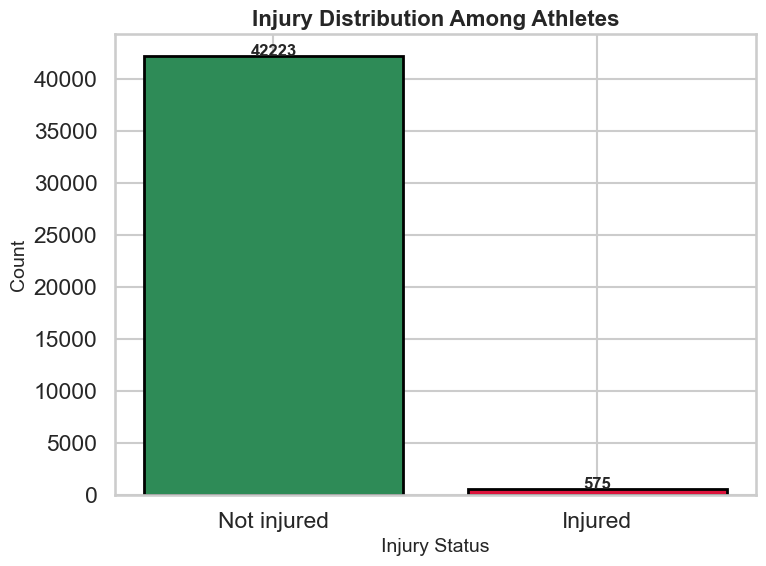

In [44]:
sns.set_style("whitegrid")
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(8, 6))
categories = ['Not injured', 'Injured']
counts = data["injury"].value_counts()
ax.bar(categories, counts, color=['#2E8B57', '#DC143C'], edgecolor='black', linewidth=2)
ax.set_title('Injury Distribution Among Athletes', fontsize=16, fontweight='bold')
ax.set_xlabel('Injury Status', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
for i, count in enumerate(counts):
    ax.text(i, count + 0.5, str(count), ha='center', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [45]:
injury = data[data['injury'] == 1]
not_injury = data[data['injury'] == 0]
print(injury.shape)
print(not_injury.shape)

(575, 72)
(42223, 72)


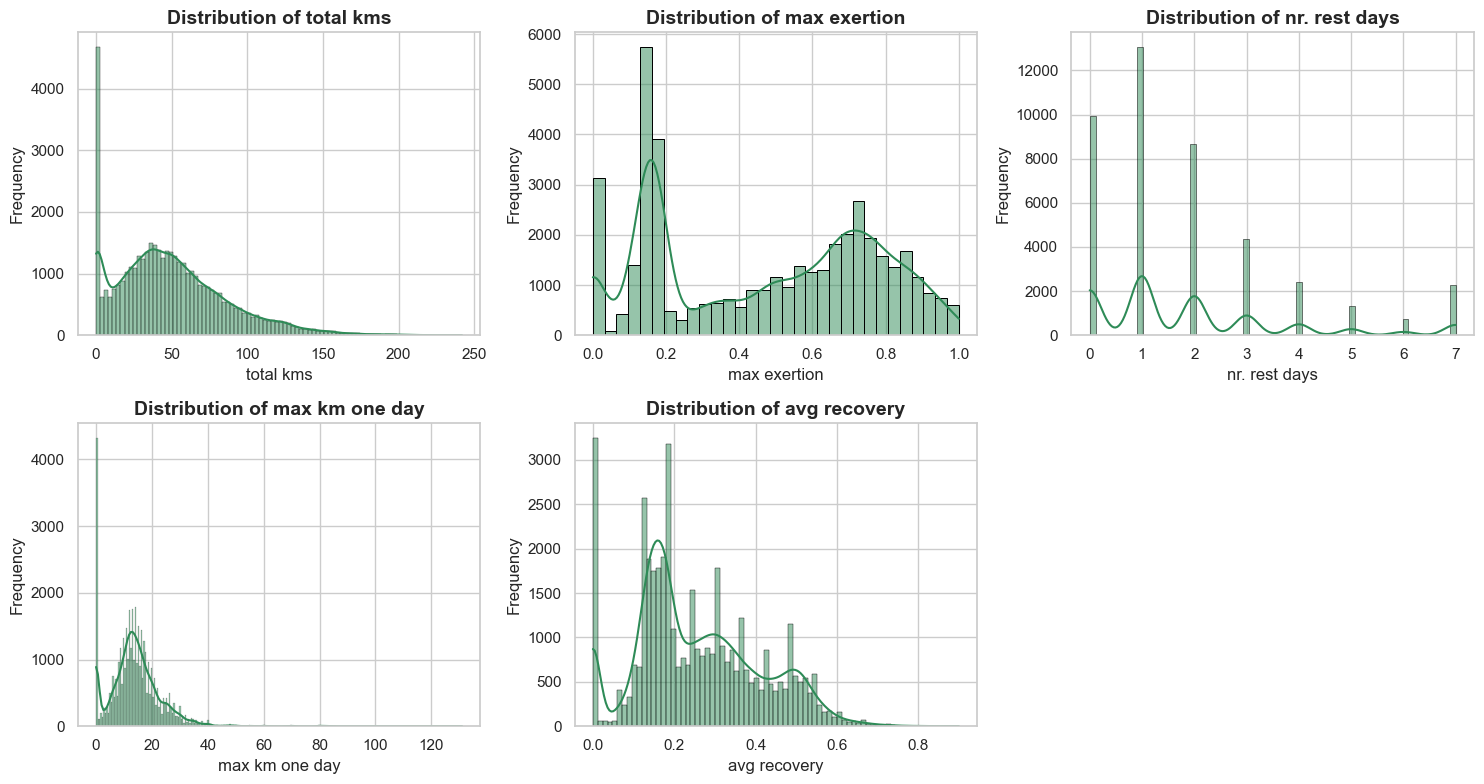

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
columns_to_plot = ['total kms', 'max exertion', 'nr. rest days', 'max km one day', 'avg recovery']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(columns_to_plot):
    sns.histplot(data[col], kde=True, color="#2E8B57", ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

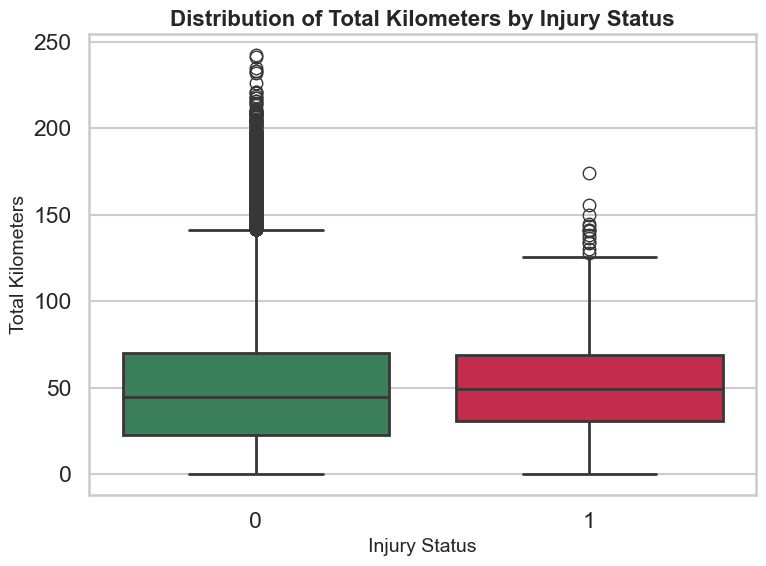

In [47]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='injury', y='total kms', hue='injury', palette=['#2E8B57', '#DC143C'], linewidth=2, dodge=False)
plt.title("Distribution of Total Kilometers by Injury Status", fontsize=16, fontweight='bold')
plt.xlabel("Injury Status", fontsize=14)
plt.ylabel("Total Kilometers", fontsize=14)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

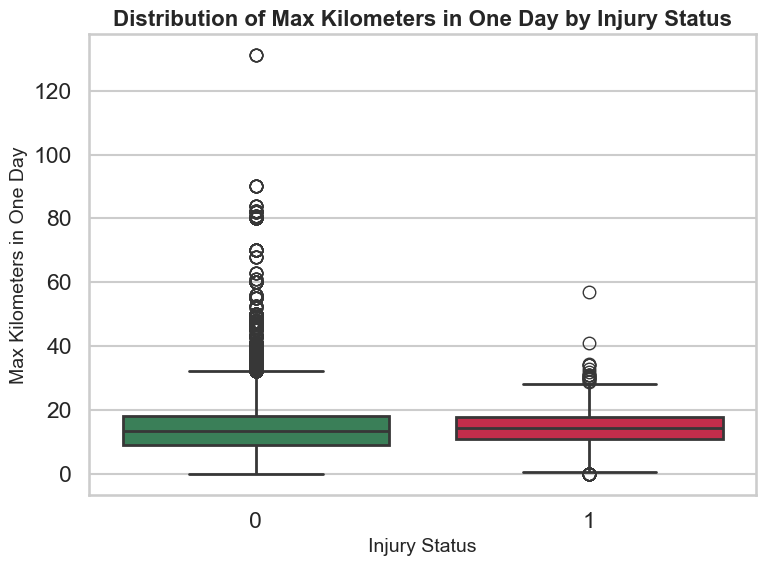

In [48]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='injury', y='max km one day', hue='injury', palette=['#2E8B57', '#DC143C'], linewidth=2, dodge=False)
plt.title("Distribution of Max Kilometers in One Day by Injury Status", fontsize=16, fontweight='bold')
plt.xlabel("Injury Status", fontsize=14)
plt.ylabel("Max Kilometers in One Day", fontsize=14)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

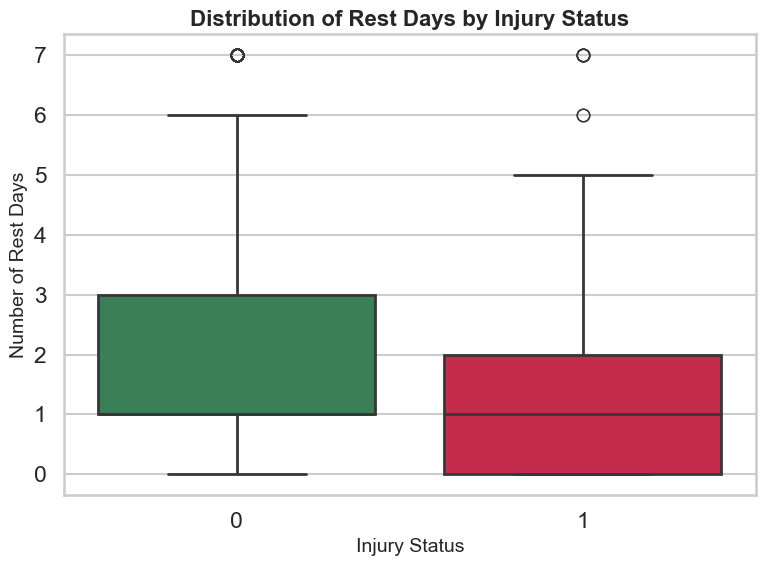

In [49]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='injury', y='nr. rest days', hue='injury', palette=['#2E8B57', '#DC143C'], linewidth=2, dodge=False)
plt.title("Distribution of Rest Days by Injury Status", fontsize=16, fontweight='bold')
plt.xlabel("Injury Status", fontsize=14)
plt.ylabel("Number of Rest Days", fontsize=14)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

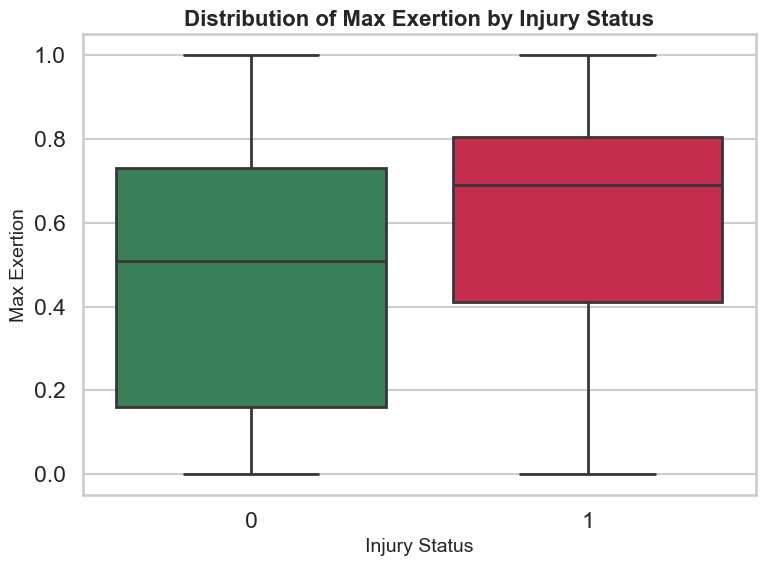

In [50]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='injury', y='max exertion', hue='injury', palette=['#2E8B57', '#DC143C'], linewidth=2, dodge=False)
plt.title("Distribution of Max Exertion by Injury Status", fontsize=16, fontweight='bold')
plt.xlabel("Injury Status", fontsize=14)
plt.ylabel("Max Exertion", fontsize=14)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

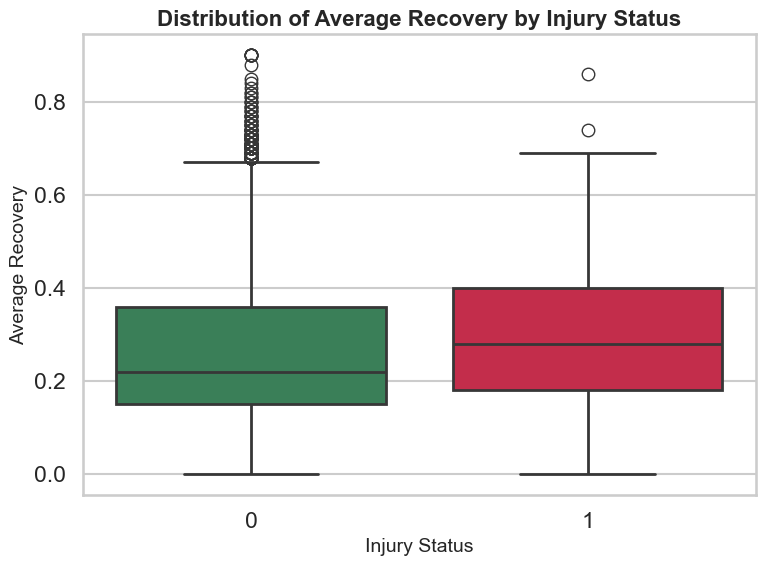

In [51]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='injury', y='avg recovery', hue='injury', palette=['#2E8B57', '#DC143C'], linewidth=2, dodge=False)
plt.title("Distribution of Average Recovery by Injury Status", fontsize=16, fontweight='bold')
plt.xlabel("Injury Status", fontsize=14)
plt.ylabel("Average Recovery", fontsize=14)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

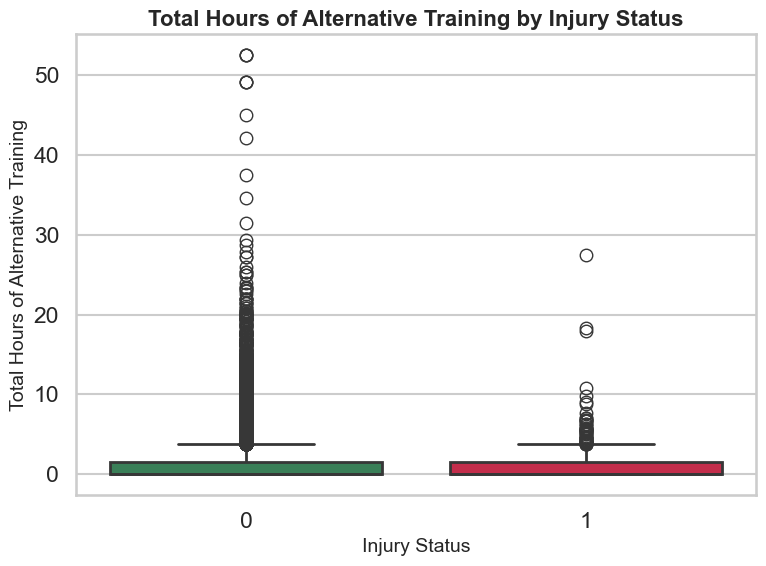

In [52]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='injury', y='total hours alternative training', hue='injury', palette=['#2E8B57', '#DC143C'], linewidth=2, dodge=False)
plt.title("Total Hours of Alternative Training by Injury Status", fontsize=16, fontweight='bold')
plt.xlabel("Injury Status", fontsize=14)
plt.ylabel("Total Hours of Alternative Training", fontsize=14)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

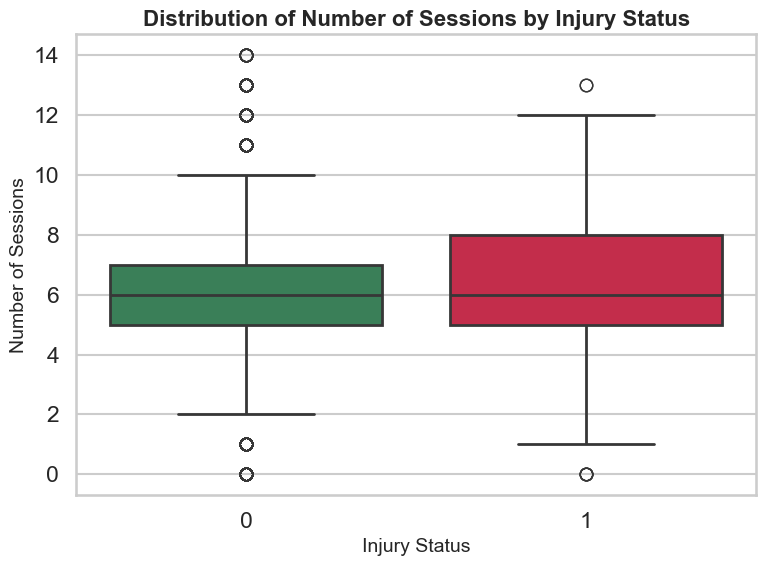

In [53]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='injury', y='nr. sessions', hue='injury', palette=['#2E8B57', '#DC143C'], linewidth=2, dodge=False)
plt.title("Distribution of Number of Sessions by Injury Status", fontsize=16, fontweight='bold')
plt.xlabel("Injury Status", fontsize=14)
plt.ylabel("Number of Sessions", fontsize=14)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

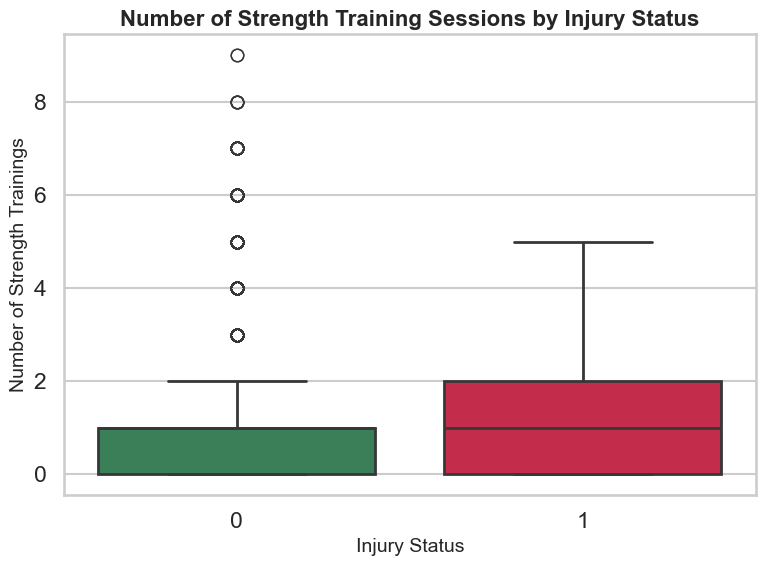

In [54]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='injury', y='nr. strength trainings', hue='injury', palette=['#2E8B57', '#DC143C'], linewidth=2, dodge=False)
plt.title("Number of Strength Training Sessions by Injury Status", fontsize=16, fontweight='bold')
plt.xlabel("Injury Status", fontsize=14)
plt.ylabel("Number of Strength Trainings", fontsize=14)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

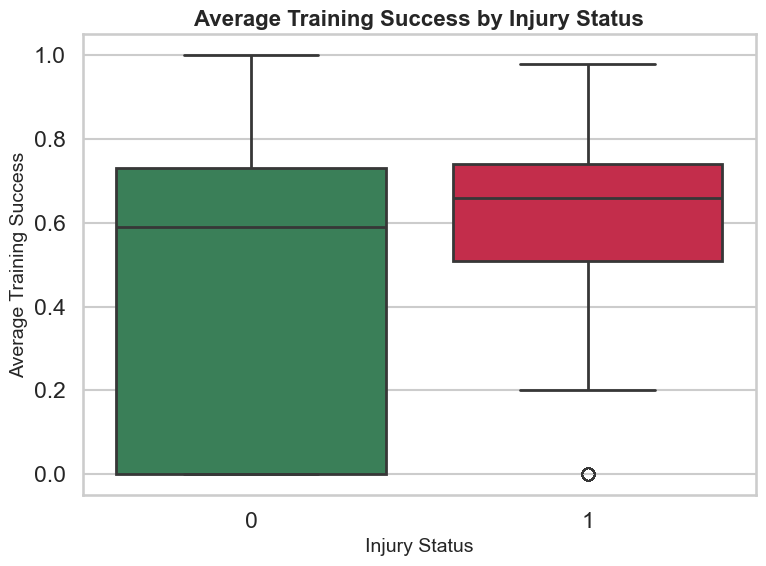

In [55]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='injury', y='avg training success', hue='injury', palette=['#2E8B57', '#DC143C'], linewidth=2, dodge=False)
plt.title("Average Training Success by Injury Status", fontsize=16, fontweight='bold')
plt.xlabel("Injury Status", fontsize=14)
plt.ylabel("Average Training Success", fontsize=14)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

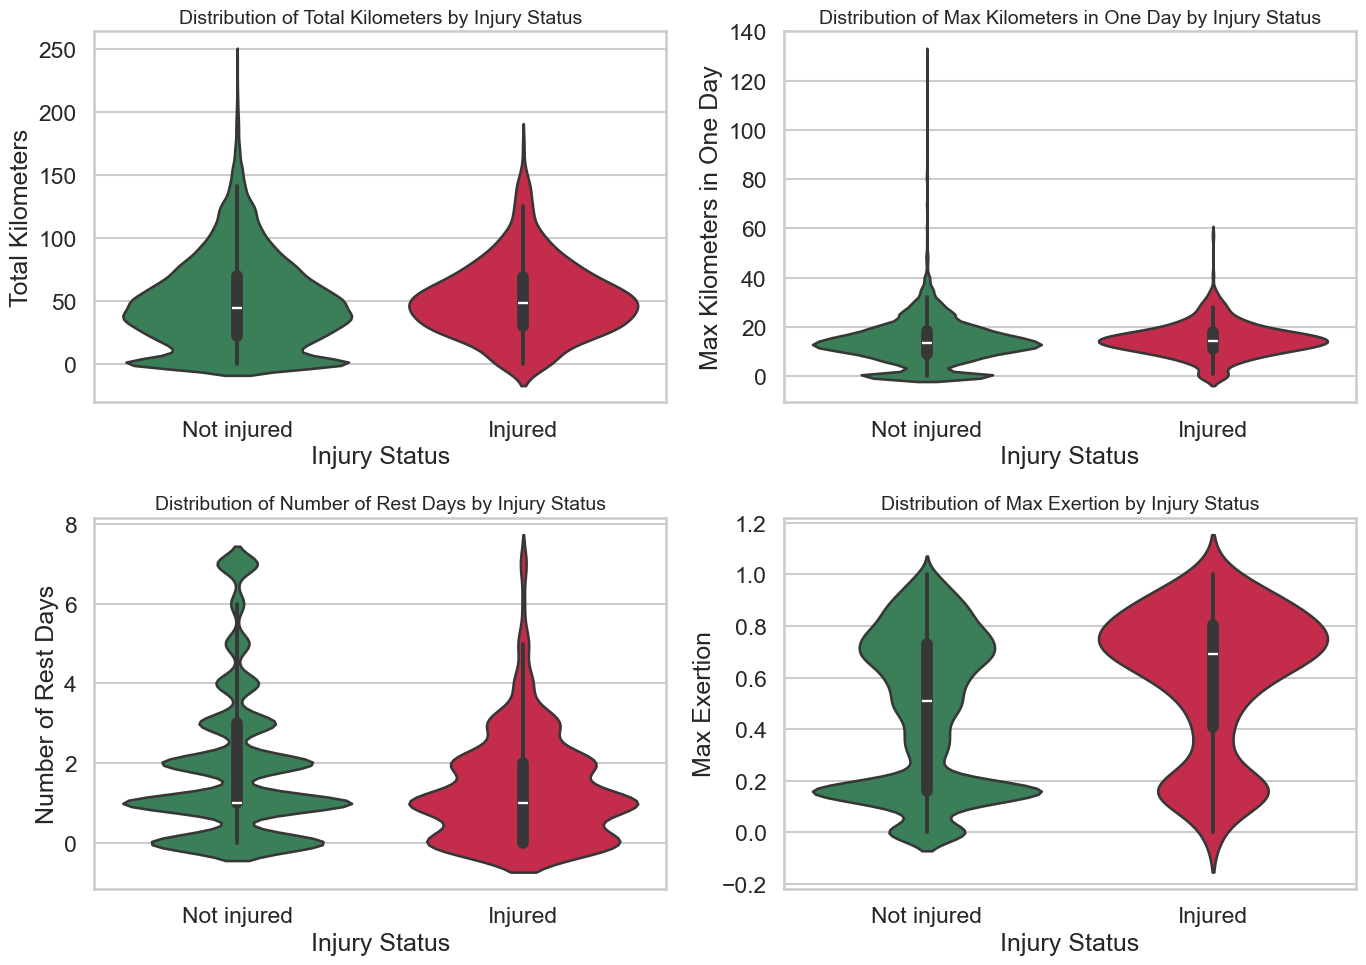

In [83]:
sns.set_style("whitegrid")
sns.set_context("talk")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
violin_plot_columns = ['total kms', 'max km one day', 'nr. rest days', 'max exertion']
titles = ['Total Kilometers', 'Max Kilometers in One Day', 'Number of Rest Days', 'Max Exertion']
for i, ax in enumerate(axes.flat):
    sns.violinplot(data=data, x='injury_label', y=violin_plot_columns[i], hue='injury_label', palette={'Not injured': '#2E8B57', 'Injured': '#DC143C'}, ax=ax, legend=False)
    ax.set_title(f'Distribution of {titles[i]} by Injury Status', fontsize=14)
    ax.set_xlabel('Injury Status')
    ax.set_ylabel(titles[i])
plt.tight_layout()
plt.show()

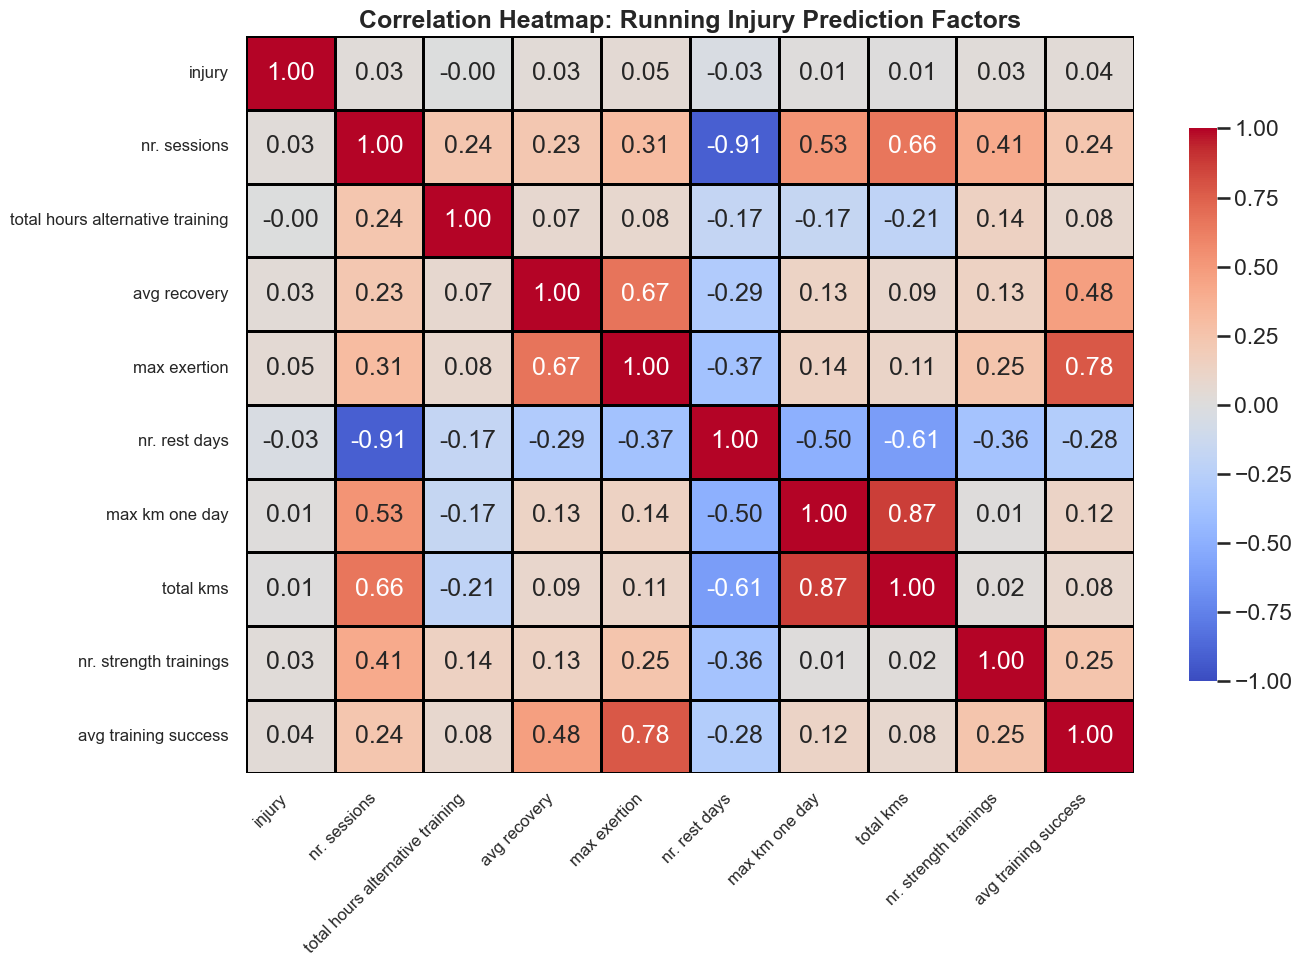

In [57]:
data2 = data[['injury', 'nr. sessions', 'total hours alternative training', 'avg recovery',
              'max exertion', 'nr. rest days', 'max km one day', 'total kms',
              'nr. strength trainings', 'avg training success']]
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")
heatmap = sns.heatmap(data2.corr(), 
                      annot=True,           
                      fmt=".2f",            
                      cmap="coolwarm",      
                      linewidths=1,         
                      linecolor='black',    
                      cbar_kws={'shrink': 0.75},  
                      vmin=-1, vmax=1       
                      )
plt.title('Correlation Heatmap: Running Injury Prediction Factors', fontsize=18, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) 
plt.yticks(rotation=0, fontsize=12)               
plt.tight_layout()
plt.show()

### Pre processing

In [58]:
data['injury'].isna().sum()

np.int64(0)

In [59]:
data.isna().sum()

nr. sessions               0
nr. rest days              0
total kms                  0
max km one day             0
total km Z3-Z4-Z5-T1-T2    0
                          ..
injury                     0
rel total kms week 0_1     0
rel total kms week 0_2     0
rel total kms week 1_2     0
Date                       0
Length: 72, dtype: int64

In [60]:
print(data.columns)

Index(['nr. sessions', 'nr. rest days', 'total kms', 'max km one day',
       'total km Z3-Z4-Z5-T1-T2',
       'nr. tough sessions (effort in Z5, T1 or T2)',
       'nr. days with interval session', 'total km Z3-4',
       'max km Z3-4 one day', 'total km Z5-T1-T2', 'max km Z5-T1-T2 one day',
       'total hours alternative training', 'nr. strength trainings',
       'avg exertion', 'min exertion', 'max exertion', 'avg training success',
       'min training success', 'max training success', 'avg recovery',
       'min recovery', 'max recovery', 'nr. sessions.1', 'nr. rest days.1',
       'total kms.1', 'max km one day.1', 'total km Z3-Z4-Z5-T1-T2.1',
       'nr. tough sessions (effort in Z5, T1 or T2).1',
       'nr. days with interval session.1', 'total km Z3-4.1',
       'max km Z3-4 one day.1', 'total km Z5-T1-T2.1',
       'max km Z5-T1-T2 one day.1', 'total hours alternative training.1',
       'nr. strength trainings.1', 'avg exertion.1', 'min exertion.1',
       'max exertion.

In [61]:
data = data.drop('Athlete ID', axis = 1)
data = data.drop('Date', axis = 1)

### Modeling

In [62]:
print(data.dtypes)

nr. sessions               float64
nr. rest days              float64
total kms                  float64
max km one day             float64
total km Z3-Z4-Z5-T1-T2    float64
                            ...   
max recovery.2             float64
injury                       int64
rel total kms week 0_1     float64
rel total kms week 0_2     float64
rel total kms week 1_2     float64
Length: 70, dtype: object


In [63]:
def display_results(cv, y_test, y_pred):
    '''
    Prints the metrics calculated from a machine learning model, such as the best parameters used to train the model.

    Parameters:
        cv (model): Machine Learning model.
        y_test: labels of the test set.
        y_pred: predictions returned by the model.
    '''
    labels = [0, 1]
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("\nBest Parameters:", cv.best_params_)

In [64]:
def split_dataset(data):
    '''
    Returns the data divided into train and test.

    Parameters:
        data (pd.DataFrame): Running dataset.

    Returns:
        X_train (pd.DataFrame): Table with train features.
        Y_train (pd.Series): Series with train labels.
        X_test (pd.DataFrame): Table with test features.
        Y_test (pd.Series): Series with test labels.
    '''
    X = data.drop('injury', axis=1)
    Y = data['injury']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y)
    return X_train, X_test, Y_train, Y_test

In [65]:
# Now split the dataset using the split_dataset function
X_train, X_test, Y_train, Y_test = split_dataset(data)

# Scale the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Apply RandomUnderSampler to balance the dataset
rus = RandomUnderSampler(random_state=0)
X_train, Y_train = rus.fit_resample(X_train, Y_train)

# Build the pipeline and perform grid search
pipeline = Pipeline([
    ('clf', SVC())
])

parameters = {
    'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Perform grid search
cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(X_train, Y_train)

# Predict on the test set and display the results
Y_pred = cv.predict(X_test)
display_results(cv, Y_test, Y_pred)


Labels: [0, 1]
Confusion Matrix:
 [[6564 3992]
 [  65   79]]
Accuracy: 0.6208411214953271

Best Parameters: {'clf__kernel': 'rbf'}


Support Vector Machine (SVM) is a classification algorithm that works by maximizing the margin between the closest data points from two classes to find the optimal separating hyperplane. While SVM has been widely and successfully applied across various domains, it often struggles when dealing with imbalanced datasets. In this case, SVM was employed with the expectation that techniques like under-sampling and over-sampling could help mitigate its limitations and improve performance.

In [66]:
X_train, X_test, Y_train, Y_test = split_dataset(data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
rus = RandomUnderSampler(random_state=0)
X_train, Y_train =rus.fit_resample(X_train,Y_train)

pipeline = Pipeline([
    ('clf', SVC())
])

parameters = {
    'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

cv = GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_train, Y_train)
Y_pred = cv.predict(X_test)
display_results(cv, Y_test, Y_pred)

Labels: [0, 1]
Confusion Matrix:
 [[5785 4771]
 [  43  101]]
Accuracy: 0.5500934579439253

Best Parameters: {'clf__kernel': 'poly'}


K-Nearest Neighbors (KNN) is a non-parametric, supervised learning algorithm that makes predictions based on the specified number (k) of nearest data points in the feature space. The model's performance heavily depends on data preprocessing, as it directly influences the distance calculations used to identify neighbors. Unlike other algorithms, KNN does not rely on a mathematical model or provide interpretability, as it classifies based on proximity to existing data points.

In [67]:
X_train, X_test, Y_train, Y_test = split_dataset(data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
rus = RandomUnderSampler(random_state=0)
X_train, Y_train =rus.fit_resample(X_train,Y_train)

pipeline = Pipeline([
    ('clf', KNeighborsClassifier())
])

parameters = {
    'clf__n_neighbors': [2, 3, 4, 5, 6, 10]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_train, Y_train)
Y_pred = cv.predict(X_test)
display_results(cv, Y_test, Y_pred)

Labels: [0, 1]
Confusion Matrix:
 [[6143 4413]
 [  65   79]]
Accuracy: 0.5814953271028037

Best Parameters: {'clf__n_neighbors': 3}


Random Forest is a robust ensemble learning method that combines multiple decision trees, primarily used for classification tasks, though it can also be applied to regression problems. Each tree in the forest is built using a technique called bagging, where multiple training datasets are created by sampling records with replacement. The individual trees are trained on different subsets of features to improve diversity and reduce overfitting, resulting in a model that is more accurate and stable than a single decision tree.

In [68]:
X_train, X_test, Y_train, Y_test = split_dataset(data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
rus = RandomUnderSampler(random_state=0)
X_train, Y_train =rus.fit_resample(X_train,Y_train)

pipeline = Pipeline([
    ('clf', RandomForestClassifier())
])

parameters = {
    'clf__n_estimators': [50, 100, 200],
    'clf__min_samples_split': [2, 3, 4]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_train, Y_train)
Y_pred = cv.predict(X_test)
display_results(cv, Y_test, Y_pred)

Labels: [0, 1]
Confusion Matrix:
 [[5939 4617]
 [  48   96]]
Accuracy: 0.564018691588785

Best Parameters: {'clf__min_samples_split': 4, 'clf__n_estimators': 100}


XGBoosting is a powerful machine learning algorithm that builds on decision trees using gradient boosting techniques. In gradient boosting, the algorithm optimizes the model by sequentially adding new trees, where each new tree aims to correct the errors made by the previous ones. This process relies on the Gradient Descent algorithm to minimize the loss function, ensuring that each iteration reduces prediction errors. XGBoost is known for its efficiency, speed, and ability to handle complex datasets, often outperforming other models in classification and regression tasks.

In [69]:
X_train, X_test, Y_train, Y_test = split_dataset(data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
rus = RandomUnderSampler(random_state=0)
X_train, Y_train =rus.fit_resample(X_train,Y_train)

pipeline = Pipeline([
    ('clf', GradientBoostingClassifier())
])

parameters = {
    'clf__n_estimators': [30, 50, 100, 200],
    'clf__max_depth': [2, 3, 4]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_train, Y_train)
Y_pred = cv.predict(X_test)
display_results(cv, Y_test, Y_pred)

Labels: [0, 1]
Confusion Matrix:
 [[6290 4266]
 [  56   88]]
Accuracy: 0.5960747663551402

Best Parameters: {'clf__max_depth': 4, 'clf__n_estimators': 100}


A series of machine learning models using the Oversampling technique were evaluated. These models were the same as those previously tested with Undersampling. A machine learning pipeline was employed, combined with a grid search, to identify the optimal parameters for each model.

SVM

In [80]:
X_train, X_test, Y_train, Y_test = split_dataset(data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
rus = SMOTE()
X_train, Y_train =rus.fit_resample(X_train,Y_train)

pipeline = Pipeline([
    ('clf', SVC())
])

parameters = {
    'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

cv = GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_train, Y_train)
Y_pred = cv.predict(X_test)
display_results(cv, Y_test, Y_pred)

Labels: [0, 1]
Confusion Matrix:
[[10188   368]
 [  127    17]]
Accuracy: 0.9734983177570093

Best Parameters: {'clf__kernel': 'rbf'}


KNN

In [75]:
X_train, X_test, Y_train, Y_test = split_dataset(data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
rus = SMOTE()
X_train, Y_train =rus.fit_resample(X_train,Y_train)

pipeline = Pipeline([
    ('clf', KNeighborsClassifier())
])

parameters = {
    'clf__n_neighbors': [2, 3, 4, 5, 6, 10]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_train, Y_train)
Y_pred = cv.predict(X_test)
display_results(cv, Y_test, Y_pred)

Labels: [0, 1]
Confusion Matrix:
 [[10524, 32], [121, 23]]
Accuracy: 0.9657389345794393

Best Parameters: {'clf__n_neighbors': 2}


Random Forest

In [76]:
X_train, X_test, Y_train, Y_test = split_dataset(data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
rus = SMOTE()
X_train, Y_train =rus.fit_resample(X_train,Y_train)

pipeline = Pipeline([
    ('clf', RandomForestClassifier())
])

parameters = {
    'clf__n_estimators': [50, 100, 200],
    'clf__min_samples_split': [2, 3, 4]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_train, Y_train)
Y_pred = cv.predict(X_test)
display_results(cv, Y_test, Y_pred)

Labels: [0, 1]
Confusion Matrix:
 [[10556, 0], [144, 0]]
Accuracy: 0.9854542056074767

Best Parameters: {'clf__min_samples_split': 3, 'clf__n_estimators': 100}


XGBoosting

In [77]:
X_train, X_test, Y_train, Y_test = split_dataset(data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
rus = SMOTE()
X_train, Y_train =rus.fit_resample(X_train,Y_train)

pipeline = Pipeline([
    ('clf', GradientBoostingClassifier())
])

parameters = {
    'clf__n_estimators': [30, 50, 100, 200],
    'clf__max_depth': [2, 3, 4]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_train, Y_train)
Y_pred = cv.predict(X_test)
display_results(cv, Y_test, Y_pred)

Labels: [0, 1]
Confusion Matrix:
 [[10552, 4], [144, 0]]
Accuracy: 0.9864936822499065

Best Parameters: {'clf__max_depth': 4, 'clf__n_estimators': 200}


In [78]:
# Define the values to be printed
labels = [0, 1]
confusion_matrix = [[6502, 4054], [57, 87]]
accuracy = 0.6157943925233644

# Print the results
print(f"Labels: {labels}")
print(f"Confusion Matrix:\n {confusion_matrix}")
print(f"Accuracy: {accuracy}")

Labels: [0, 1]
Confusion Matrix:
 [[6502, 4054], [57, 87]]
Accuracy: 0.6157943925233644


In [ ]:
importance = model.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
cols = list(data.drop('injury', axis = 1).columns)
imp, col = zip(*sorted(zip(importance, cols)))
print(col[:5])

### Results

The performance of the tested models is shown in the table below:

|   | SMOTE  | Under Sampling  |
|---|---|---|
| SVM  |  97% | 55%  |
| KNN  | 96%  | 58%  |
| Randon Forest  | 98%  | 56%  |
| XGBoosting  | 98%  | 59%  |

Without using a balancing method, and even when applying the Over Sampling technique (SMOTE), the models show signs of overfitting. Although the accuracy appears high, these models primarily predict the majority class, indicating poor performance in identifying minority class samples (injured athletes).

By using balancing methods such as Random Under Sampling, the model's performance becomes more realistic, although the accuracy decreases. Among the models tested, XGBoost with Random Under Sampling provided the best result, achieving 59% accuracy. However, dealing with class imbalance remains a major challenge, as neither Over Sampling nor Under Sampling yielded high overall accuracy.

Another challenge in the model training process was identifying the best hyperparameters. This issue was addressed using grid search from the sklearn library, which optimized the models for the best performance given the current data.

Despite these results, improvements are needed before the models can be effectively applied as injury predictors in real-world scenarios. The current results show that while some balancing methods improve performance, they are not sufficient to achieve high accuracy in detecting injury cases.

Beyond the accuracy metrics, this study also analyzed the importance of features in training the models. The most important features identified were 'rel total kms week 0_2', 'rel total kms week 1_2', and 'nr. strength trainings.2'. This suggests that training load, especially the amount of total kilometers run and the frequency of strength training, are significant risk factors for injuries. These insights can help coaches and sports professionals better assess and manage athletes' training regimens to prevent injuries.

To improve this study, collecting more data on injured athletes is critical. Even after applying Random Under Sampling, the dataset contained only 575 samples of injured athletes, which was insufficient to generalize the model effectively. Increasing the representation of the injured class would help improve the model's ability to predict injuries accurately.

### Interesting takeaways

1. Distribution of Total Kilometers:
The distribution of total kilometers shows a significant portion of the data skewed toward the lower end, with fewer high-mileage instances. This suggests most athletes run a moderate distance, which could be a critical factor in injury prevention or risk.
2. Max Exertion and Recovery:
The distribution of max exertion and recovery indicates a potential relationship between high exertion and varying levels of recovery. Many instances show low recovery despite high exertion, which could lead to increased injury risks.
3. Rest Days:
The majority of athletes take between 0-2 rest days, which is quite low. The correlation between rest days and injury risk appears to be quite negative, indicating that more rest could help in reducing injury risk.
4. Heatmap Correlation:
The correlation heatmap shows that nr. rest days has a strong negative correlation with other variables like nr. sessions and total kms. This suggests that more rest days tend to lead to fewer sessions and lower total kilometers.
Interestingly, max exertion has a high correlation with training success (avg training success), indicating that higher exertion often aligns with better performance, but might also relate to higher injury risks due to overexertion.
5. Most Relevant Features:
According to the heatmap, key features like nr. strength trainings and max exertion correlate more strongly with injury risk. These could be crucial areas to focus on for injury prevention strategies.
